# DL Assignment 3: Part 3

**Q10:**

Using the following formulas and parameters we can work out the output dimensions as follows:

$
n_{H|W}^{[l]} = \frac{n_{H|W}^{[l-1]} + 2p^{[l-1]}-f^{[l-1]}}{s^{[l-1]}} + 1
$

$
n_{H}^{[l-1]} = 768, n_{W}^{[l-1]} = 1024, p = 1, s = 2, k = 5 \times 5
$

$
n_{H}^{[l]} = 383.5, n_{W}^{[l]} = 511.5
$

When the kernel size does not fit an even amount of times in an input dimension, the dimension in question is floored (https://discuss.pytorch.org/t/how-to-keep-output-size-identic-with-input-size/84025), which means that the output heights and widths will turn out to be 383 and 511 pixels respectively. Applying convolution with the aforementioned settings will thus lead to output tensor $Y \in \mathbb{R}^{16 \times 511 \times 383}$.

We can apply the same calculations to an input image tensor $X \in \mathbb{R}^{8 \times 1920 \times 1080}$ to get an output tensor $Y \in \mathbb{R}^{16 \times 959 \times 539}$

**Q11:**

Input tensor: $X \in \mathbb{R}^{16 \times 3 \times 32 \times 32}$
```
X = torch.randn(16,3,32,32)
```

Global max pool: ``` X_maxpool = X.amax([2,3]) ```


Global mean pool: ``` X_meanpool = X.mean([2,3]) ```

**Q12:**



In [1]:
# Extract dataset (perform only once! -> 280 MB file)
# Make sure MNIST data (.tgz file) is in current directory
import tarfile
import os

with tarfile.open("mnist-varres.tgz", "r:gz") as tar:
    tar.extractall()

FileNotFoundError: [Errno 2] No such file or directory: 'mnist-varres.tgz'

In [3]:
# Define custom dataset
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

IMG_TRANSFORM = transforms.Compose([
    transforms.Grayscale(), # Reduce to one channel (grayscale image)
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

BATCH_SIZE = 16

train_data = torchvision.datasets.ImageFolder(root = "mnist-varres/train",
                                             transform = IMG_TRANSFORM)
test_data = torchvision.datasets.ImageFolder(root = "mnist-varres/test",
                                            transform = IMG_TRANSFORM)
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [4]:
data, _ = next(iter(train_loader))

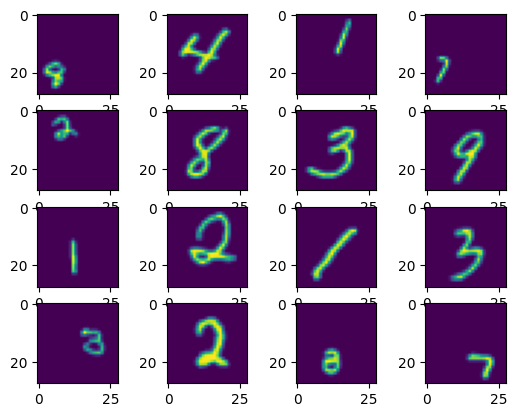

In [5]:
fig, axs = plt.subplots(4, 4)
it = 0
for i in range(4):
    for j in range(4):
        axs[i][j].imshow(data[it][0])
        it += 1

## 13

Resizing all images to 64×64 makes the dataset uniform and easier to process but it has downsides. First, it increases computational cost because larger images require more memory and processing time. Second, resizing smaller images either adds black padding (by making the digits appear smaller relative to the image) or it uses interpolation (which can distort the digits and add irrelevant information). Conseqently this can affect operations like global average pooling, where padding values are included in the calculation therefore weakening the signal. Finally, resizing removes the resolution diversity of the dataset, which is important for creating models that can adapt to real-world variations. Therefore, eventhough resizing offers consistency, designing a model that can handle differnt resolutions is more efficient and keeps the dataset’s unique advantages.

# 14

Load the Data into Memory as Tensors
- Use the glob module to find all images grouped by resolution.
- Apply torchvision.transforms to process images into tensors.


we loaded the data into memory as three tensors—one for each resolution (32x32, 48x48, 64x64), and implemented a training loop that handles each resolution separately. 

In [6]:
from glob import glob
from torchvision.transforms import Compose, Grayscale, ToTensor
from PIL import Image
import torch

# Define transformations
transform = Compose([Grayscale(), ToTensor()])

# Initialize lists for images and labels
data_32, labels_32 = [], []
data_48, labels_48 = [], []
data_64, labels_64 = [], []

# Load images and infer resolution
for filepath in glob("mnist-varres/train/**/*.png", recursive=True):
    image = Image.open(filepath)
    label = int(filepath.split("/")[-2])  # Extract label from directory name
    
    # Get image dimensions to determine resolution
    width, height = image.size
    if width == 32 and height == 32:
        data_32.append(transform(image))
        labels_32.append(label)
    elif width == 48 and height == 48:
        data_48.append(transform(image))
        labels_48.append(label)
    elif width == 64 and height == 64:
        data_64.append(transform(image))
        labels_64.append(label)

# Convert lists to tensors
data_32, labels_32 = torch.stack(data_32), torch.tensor(labels_32)
data_48, labels_48 = torch.stack(data_48), torch.tensor(labels_48)
data_64, labels_64 = torch.stack(data_64), torch.tensor(labels_64)

# Print dataset shapes
print(f"Data 32x32: {data_32.shape}, Labels: {labels_32.shape}")
print(f"Data 48x48: {data_48.shape}, Labels: {labels_48.shape}")
print(f"Data 64x64: {data_64.shape}, Labels: {labels_64.shape}")


Data 32x32: torch.Size([19913, 1, 32, 32]), Labels: torch.Size([19913])
Data 48x48: torch.Size([20080, 1, 48, 48]), Labels: torch.Size([20080])
Data 64x64: torch.Size([20007, 1, 64, 64]), Labels: torch.Size([20007])


This means:

- 32x32: 19,913 samples  
- 48x48: 20,080 samples
- 64x64: 20,007 samples

Define the model: this model is a convolutional neural network (CNN) capable of handling variable resolutions, we will use the architecture provided.

In a more realistic scenario where most images have unique resolutions, it becomes challenging to process each resolution separately because tensors in a batch must have the same shape. A practical approach to adapt to this situation is to define a few fixed resolutions and resize all images to the nearest one. This minimizes changes to the inputs while ensuring they can be processed in batches effectively.

In [7]:
import torch
import torch.nn as nn

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VariableResolutionModel(nn.Module):
    def __init__(self, num_classes=10, num_channels=64):  # Adjust N here
        super(VariableResolutionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  # Global max pooling
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        #x = x.mean([2,3])
        x = x.max([2,3])
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

model = VariableResolutionModel(num_classes=10, num_channels=64).to(device)


Previous steps together with the Training loop :

In [12]:
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Grayscale, ToTensor
from PIL import Image
from glob import glob
import numpy as np
from tqdm.notebook import tqdm

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Transformations
transform = Compose([Grayscale(), ToTensor()])

# Initialize dictionaries for data and labels
data_train = {32: [], 48: [], 64: []}
labels_train = {32: [], 48: [], 64: []}

# Load images and infer resolution
for filepath in glob("mnist-varres/train/**/*.png", recursive=True):
    image = Image.open(filepath)
    label = int(filepath.split("/")[-2])  # Extract label from directory name
    
    # Get image dimensions to determine resolution
    width, height = image.size
    if (width, height) == (32, 32):
        data_train[32].append(transform(image))
        labels_train[32].append(label)
    elif (width, height) == (48, 48):
        data_train[48].append(transform(image))
        labels_train[48].append(label)
    elif (width, height) == (64, 64):
        data_train[64].append(transform(image))
        labels_train[64].append(label)

# Convert lists to tensors
for res in data_train:
    data_train[res] = torch.stack(data_train[res])
    labels_train[res] = torch.tensor(labels_train[res])

# Function to split data into training and validation sets
def split_data(data, labels, train_ratio=0.8):
    data_train, data_val = {}, {}
    labels_train, labels_val = {}, {}
    for res in data:
        combined = list(zip(data[res], labels[res]))
        np.random.shuffle(combined)
        shuffled_data, shuffled_labels = zip(*combined)
        
        total_samples = len(shuffled_data)
        split_idx = int(total_samples * train_ratio)
        
        data_train[res] = torch.stack(shuffled_data[:split_idx])
        data_val[res] = torch.stack(shuffled_data[split_idx:])
        labels_train[res] = torch.tensor(shuffled_labels[:split_idx])
        labels_val[res] = torch.tensor(shuffled_labels[split_idx:])
    return data_train, labels_train, data_val, labels_val

# Split data into training and validation sets
data_train, labels_train, data_val, labels_val = split_data(data_train, labels_train)

# Print dataset shapes
for res in data_train:
    print(f"Resolution {res}x{res} - Training: {data_train[res].shape}, Validation: {data_val[res].shape}")

# Define the model
class VariableResolutionModel(nn.Module):
    def __init__(self, num_classes=10, num_channels=82):
        super(VariableResolutionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  # Global max pooling
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.mean([2,3])
        #x = x.amax([2,3])
        #x = self.global_pool(x)
        #x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

model = VariableResolutionModel(num_classes=10, num_channels=82).to(device)

# Define hyperparameters
NUM_EPOCHS = 15
BATCH_SIZE = 16
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists for accuracies
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()

    # Training loop over resolutions
    for resolution in data_train:
        if len(data_train[resolution]) == 0:
            print(f"Skipping resolution {resolution} due to empty data.")
            continue

        current_data = data_train[resolution].to(device)
        current_labels = labels_train[resolution].to(device)

        # Manually batchify training data
        n_batches = int(np.ceil(len(current_data) / BATCH_SIZE))
        for i in range(n_batches):
            start = i * BATCH_SIZE
            end = min(start + BATCH_SIZE, len(current_data))
            batch_data = current_data[start:end]
            batch_labels = current_labels[start:end]

            # Forward and backward pass
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_labels).sum().item()
            total_train += batch_labels.size(0)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for resolution in data_val:
            if len(data_val[resolution]) == 0:
                print(f"Skipping resolution {resolution} due to empty data.")
                continue

            current_data = data_val[resolution].to(device)
            current_labels = labels_val[resolution].to(device)

            # Manually batchify validation data
            n_batches = int(np.ceil(len(current_data) / BATCH_SIZE))
            for i in range(n_batches):
                start = i * BATCH_SIZE
                end = min(start + BATCH_SIZE, len(current_data))
                batch_data = current_data[start:end]
                batch_labels = current_labels[start:end]

                outputs = model(batch_data)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == batch_labels).sum().item()
                total_val += batch_labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Final output
print(f"Final Training Accuracy: {train_accuracies[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")


Resolution 32x32 - Training: torch.Size([15930, 1, 32, 32]), Validation: torch.Size([3983, 1, 32, 32])
Resolution 48x48 - Training: torch.Size([16064, 1, 48, 48]), Validation: torch.Size([4016, 1, 48, 48])
Resolution 64x64 - Training: torch.Size([16005, 1, 64, 64]), Validation: torch.Size([4002, 1, 64, 64])


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15
Training Loss: 1902.8764, Training Accuracy: 80.22%
Validation Accuracy: 90.99%
Epoch 2/15
Training Loss: 667.5918, Training Accuracy: 93.99%
Validation Accuracy: 94.26%
Epoch 3/15
Training Loss: 486.9098, Training Accuracy: 95.57%
Validation Accuracy: 95.77%
Epoch 4/15
Training Loss: 396.8396, Training Accuracy: 96.50%
Validation Accuracy: 96.76%
Epoch 5/15
Training Loss: 326.6117, Training Accuracy: 97.10%
Validation Accuracy: 97.28%
Epoch 6/15
Training Loss: 281.6155, Training Accuracy: 97.55%
Validation Accuracy: 97.64%
Epoch 7/15
Training Loss: 241.9300, Training Accuracy: 97.86%
Validation Accuracy: 97.88%
Epoch 8/15
Training Loss: 211.1984, Training Accuracy: 98.10%
Validation Accuracy: 98.03%
Epoch 9/15
Training Loss: 186.6688, Training Accuracy: 98.34%
Validation Accuracy: 98.14%
Epoch 10/15
Training Loss: 169.6647, Training Accuracy: 98.50%
Validation Accuracy: 98.34%
Epoch 11/15
Training Loss: 156.1897, Training Accuracy: 98.62%
Validation Accuracy: 98.36%
Epoch 1

# 15

BaselineNetwork:
- Implements a fixed resolution network.
- Includes 3 convolutional layers followed by max-pooling and a fully connected layer.
- Calculates the total number of trainable parameters.

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Baseline Network
class BaselineNetwork(nn.Module):
    def __init__(self):
        super(BaselineNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 3 * 3, 10)  # Fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.fc(x)
        return x

baseline_model = BaselineNetwork()
baseline_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)
print(f"Total trainable parameters in Baseline Network: {baseline_params}")


Total trainable parameters in Baseline Network: 29066


FlexibleResolutionNet:
- Implements a variable resolution network.
- Includes 3 convolutional layers with configurable output channels (channels parameter).
- Uses adaptive average pooling instead of hardcoded pooling.
- Calculates trainable parameters for different channel configurations.


In [41]:
# Variable Resolution Network
class FlexibleResolutionNet(nn.Module):
    def __init__(self, output_classes=10, channels=82):  # Adjustable number of channels
        super(FlexibleResolutionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global pooling layer
        self.fc = nn.Linear(channels, output_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.fc(x)
        return x

# Experiment with different channel sizes for FlexibleResolutionNet
channel_values = [64, 82, 128]  # Replace 82 with other values to match parameter counts if needed
for channels in channel_values:
    variable_res_model = FlexibleResolutionNet(channels=channels)
    variable_res_params = sum(p.numel() for p in variable_res_model.parameters() if p.requires_grad)
    print(f"Total trainable parameters in Variable Resolution Network (Channels={channels}): {variable_res_params}")


Total trainable parameters in Variable Resolution Network (Channels=64): 23946
Total trainable parameters in Variable Resolution Network (Channels=82): 29328
Total trainable parameters in Variable Resolution Network (Channels=128): 43082


To match the parameter count of the baseline network (29,066 parameters), we tested different values for \( N \) in the variable resolution network. With \( N=64 \), the network had 23,946 parameters (fewer than the baseline), and with \( N=128 \), it had 43,082 parameters (exceeding the baseline). Using \( N=82 \), the variable resolution network had 29,328 parameters, closely matching the baseline, allowing for a fair comparison. Parameter counts were computed using model.parameters() by summing all trainable tensors, independent of input resolution.

## 16

In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Grayscale, ToTensor
from PIL import Image
from glob import glob
import numpy as np

# Define device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Transformations
transform = Compose([Grayscale(), ToTensor()])

# Initialize dictionaries for data and labels
data_train = {32: [], 48: [], 64: []}
labels_train = {32: [], 48: [], 64: []}

# Load images and infer resolution
for filepath in glob("mnist-varres/train/**/*.png", recursive=True):
    image = Image.open(filepath)
    label = int(filepath.split("/")[-2])  # Extract label from directory name
    
    # Get image dimensions to determine resolution
    width, height = image.size
    if (width, height) == (32, 32):
        data_train[32].append(transform(image))
        labels_train[32].append(label)
    elif (width, height) == (48, 48):
        data_train[48].append(transform(image))
        labels_train[48].append(label)
    elif (width, height) == (64, 64):
        data_train[64].append(transform(image))
        labels_train[64].append(label)

# Convert lists to tensors
for res in data_train:
    data_train[res] = torch.stack(data_train[res])
    labels_train[res] = torch.tensor(labels_train[res])

# Function to split data into training and validation sets
def split_data(data, labels, train_ratio=0.8):
    data_train, data_val = {}, {}
    labels_train, labels_val = {}, {}
    for res in data:
        combined = list(zip(data[res], labels[res]))
        np.random.shuffle(combined)
        shuffled_data, shuffled_labels = zip(*combined)
        
        total_samples = len(shuffled_data)
        split_idx = int(total_samples * train_ratio)
        
        data_train[res] = torch.stack(shuffled_data[:split_idx])
        data_val[res] = torch.stack(shuffled_data[split_idx:])
        labels_train[res] = torch.tensor(shuffled_labels[:split_idx])
        labels_val[res] = torch.tensor(shuffled_labels[split_idx:])
    return data_train, labels_train, data_val, labels_val

# Split data into training and validation sets
data_train, labels_train, data_val, labels_val = split_data(data_train, labels_train)

# Print dataset shapes
for res in data_train:
    print(f"Resolution {res}x{res} - Training: {data_train[res].shape}, Validation: {data_val[res].shape}")

# Define the model
class VariableResolutionModel(nn.Module):
    def __init__(self, num_classes=10, num_channels=82):
        super(VariableResolutionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))  # Global max pooling
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.mean([2,3])
        
        #x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

model = VariableResolutionModel(num_classes=10, num_channels=64).to(device)

# Define hyperparameters
NUM_EPOCHS = 15
BATCH_SIZE = 16
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists for accuracies
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()

    # Training loop over resolutions
    for resolution in data_train:
        if len(data_train[resolution]) == 0:
            print(f"Skipping resolution {resolution} due to empty data.")
            continue

        current_data = data_train[resolution].to(device)
        current_labels = labels_train[resolution].to(device)

        # Manually batchify training data
        n_batches = int(np.ceil(len(current_data) / BATCH_SIZE))
        for i in range(n_batches):
            start = i * BATCH_SIZE
            end = min(start + BATCH_SIZE, len(current_data))
            batch_data = current_data[start:end]
            batch_labels = current_labels[start:end]

            # Forward and backward pass
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_labels).sum().item()
            total_train += batch_labels.size(0)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%")

    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for resolution in data_val:
            if len(data_val[resolution]) == 0:
                print(f"Skipping resolution {resolution} due to empty data.")
                continue

            current_data = data_val[resolution].to(device)
            current_labels = labels_val[resolution].to(device)

            # Manually batchify validation data
            n_batches = int(np.ceil(len(current_data) / BATCH_SIZE))
            for i in range(n_batches):
                start = i * BATCH_SIZE
                end = min(start + BATCH_SIZE, len(current_data))
                batch_data = current_data[start:end]
                batch_labels = current_labels[start:end]

                outputs = model(batch_data)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == batch_labels).sum().item()
                total_val += batch_labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Final output
print(f"Final Training Accuracy: {train_accuracies[-1] * 100:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1] * 100:.2f}%")


RuntimeError: stack expects a non-empty TensorList